# Let's Face It 

**Team Members:** Georgiy Sekretaryuk, Rafael Arbex-Murut, Yeshwanth Somu

**Data Set:** Facial Recognition Dataset
- https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset?select=Testing

**Data Set Description:**

This dataset contains folders pertaining to different expressions of the human face, such as Surprise, Anger, Happiness, Sad, Neutral, Fear. The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The purpose of this project is to analyze facial images to predict emotion.

**Number of Attributes:** 2304

**Attribute Description:** Each attribute is a grayscale value of each of the 48 x 48 pixels.

**Data Source:** Kaggle

In [1]:
# SETUP

import os
from PIL import Image as Image
from IPython.display import Image as displayImage
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from tensorflow import keras
from keras import metrics
from sklearn import metrics

import utils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

tf.get_logger().setLevel('INFO')

## Recap from Baseline Model

In our previous Baseline_Model.ipynb file we conducted pixel analysis on the images and developed our baseline FNN Model.

The FNN model performance was very poor. It overpredicted the Happy images in the output, so the Happy label had a high recall but the others had much lower recalls. 

However, the precision was above random guessing based on the image distribution for the dataset. 

The FNN model performed a bit better than guessing, so we determined that it will be our baseline model.

## Loading Data

First we load the images from the folder. 

The original dataset is split into a testing and training folder. Each folder contains 6 folders for 6 emotions, named for each emotion. We will cycle through and extract the training/testing images, flatten them, and place them in the appropriate X_train / X_test variables. The labels will be placed in the correspending Y_train / Y_test variables.

The dataset is split into an 80% training / 20% testing dataset.

In [41]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label_mapping):
    images = []
    labels = []

    #load each image file
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))

        #check if loaded properly
        if img is not None:

            images.append(np.array(img)) #turn image to array
            # print(folder_path)
            folder_path = folder_path.replace("\\", "/")
            folder_name = folder_path.split("/")[-1]  # Extract folder name from path
            # print(folder_name)
            label = label_mapping[folder_name]  # Assign label based on folder name
            labels.append(label)  # Assign the folder index as the label

    return images, labels

def load_dataset(data_folder, return_label_names=False):
    X = []
    Y = []

    label_mapping = {}  # Dictionary to map folder names to label values
    label_counter = 0

    #cycle through each folder, get folder path
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        # print("Load_dataset is looping through", folder_path)

        #check if a folder or a stray file
        if os.path.isdir(folder_path):

            #count folders to assign index
            label_mapping[folder_name] = label_counter
            label_counter += 1

            #load images and labels, add to X/Y list
            images, labels = load_images_from_folder(folder_path, label_mapping)
            X.extend(images)
            Y.extend(labels)
    
        else:
            print(f"{folder_path} is not a folder.")

    #pull out label names
    label_names = list(label_mapping.keys())

    if return_label_names:
        label_names = list(label_mapping.keys())
        return np.array(X), np.array(Y), label_names
    else:
        return np.array(X), np.array(Y)

# Load the training dataset
train_folder = 'data/Training/Training'
X_train, Y_train, label_names = load_dataset(train_folder, return_label_names=True)

# Load the testing dataset
test_folder = 'data/Testing/Testing'
X_test, Y_test, = load_dataset(test_folder)

# Flatten the label vectors
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


data/Testing/Testing/.DS_Store is not a folder.


Print the shapes below to confirm the size of each dataset as well as the label names.

In [42]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print(label_names)
# print(Y_train)

X_train.shape: (28273, 48, 48)
Y_train.shape: (28273,)
X_test.shape: (7067, 48, 48)
Y_test.shape: (7067,)
['Happy', 'Sad', 'Fear', 'Neutral', 'Angry', 'Suprise']


We'll print the count and percentage of each emotion to understand the training dataset that we're working with a bit better:

In [4]:
emotion_counts = pd.Series(Y_train).value_counts()
emotion_counts.index = emotion_counts.index.map(lambda x: label_names[x])
percentage_series = ((emotion_counts / len(Y_train))*100).apply(lambda x: f'{x:.2f}') + '%'
emotion_counts = pd.concat([emotion_counts, percentage_series],axis=1)
emotion_counts.columns = ['Count', 'Percentage']

print(emotion_counts)

         Count Percentage
Happy     7215     25.52%
Neutral   4965     17.56%
Sad       4830     17.08%
Fear      4097     14.49%
Angry     3995     14.13%
Suprise   3171     11.22%


And we plot the distribution on a histogram:

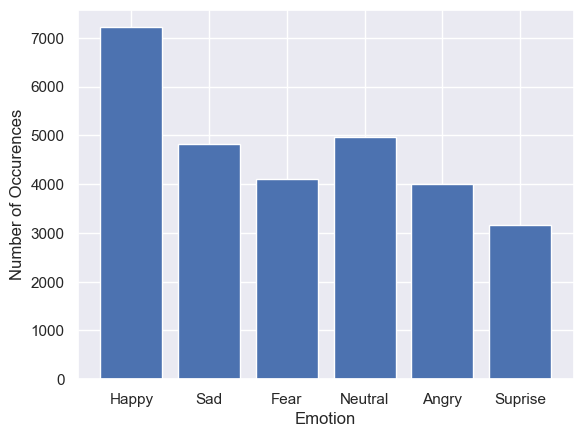

In [5]:
n = [len(Y_train[Y_train == 0]), len(Y_train[Y_train == 1]), len(Y_train[Y_train == 2]), len(Y_train[Y_train == 3]), len(Y_train[Y_train == 4]), len(Y_train[Y_train == 5])]
plt.bar(label_names, n)
plt.xlabel("Emotion")
plt.ylabel ("Number of Occurences")
plt.show()

Each matrix contains an image represent by a value from 0 to 255 for each of the pixels in the 48x48 pixel array. We will normalize the values to get a matrix with values from 0 to 1.

In [6]:
X_train = X_train / 255
X_test = X_test / 255

## Visualizing Images in Dataset

Next, we will visualizes the images in the dataset for each emotion to view a sample of the dataset that we're working with.

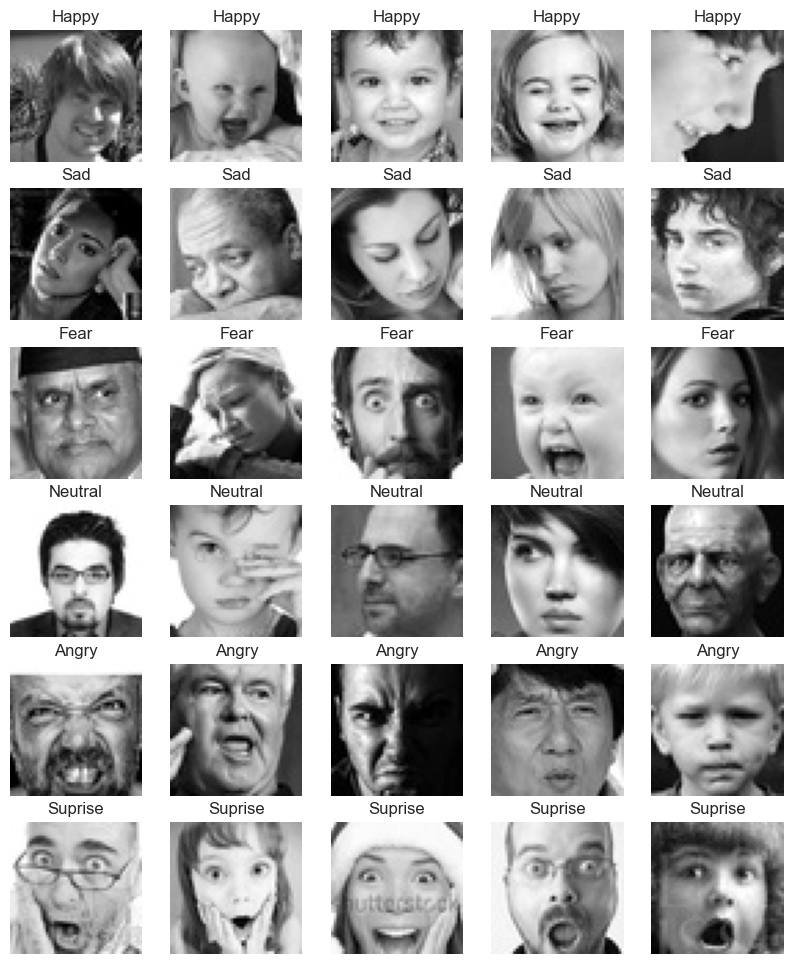

In [7]:
#plot 5 images for each label

num_images_to_show = 5

fig, axs = plt.subplots(len(label_names), ncols=num_images_to_show, figsize=(10, 12))
for label in range(len(label_names)):
    counter = 0 
    for i in range(len(Y_train)):
        if Y_train[i] == label:
            image = X_train[i]
            axs[label, counter].imshow(image, cmap='gray')
            axs[label, counter].set_title(label_names[label])
            axs[label, counter].axis('off')
            counter += 1

            #if loaded 5 images per row/label, break
            if counter == 5:  
                break
plt.show()

## Building the Initial CNN Model - First Attempt

Now we will attempt to build a Convolutional Neural Network model to perform emotional facial analysis on the images in the dataset. 

Our previous FNN model had poor performance - as we suspected it would have. Preliminary pixel analysis had shown us that there was little difference between the different categories of emotions.

A CNN model would be better suited for a facial recognition task like this. The CNN model filters can be modified to detect patterns among images (such as eyes, lips, mouth, etc), and commonalities among these patterns will likely help us predict emotions with a higher accuracy.

This is our first attempt at buildi the CNN Model.

In [8]:
#Checking the shape on data
X_train.shape
Y_train.shape

(28273,)

In [9]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

This is where the model gets buildt. 

It's a sequential model with two sets of convolutional layers followed by a pooling layer. Then some additional layers are added. All the layers are visible once this block is run. 

This CNN model is similar to what we did in the homework assignment. We decided to use this simple CNN model as our first attempt.

The biggest change to note here is that the activation function for the last layer is softmax, as this is a multiclass classification problem.

In [10]:
CNN_1 = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
CNN_1.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
CNN_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
##Same as hw
CNN_1.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
CNN_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
CNN_1.add(tf.keras.layers.Flatten()) 
CNN_1.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
CNN_1.add(tf.keras.layers.Dropout(
    rate=0.5))

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
CNN_1.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
CNN_1.build(input_shape=(None, 48, 48, 1))
CNN_1.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 24, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              9438208   
                                         

In [11]:
##Changes optimizer and loss
CNN_1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [12]:
##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history_CNN_1 = CNN_1.fit(X_train, Y_train,
                    epochs=10, 
                    validation_data=(X_test, Y_test)
)

Epoch 1/10
884/884 [==============================] - 22s 24ms/step - loss: 1.5850 - accuracy: 0.3608 - val_loss: 1.4683 - val_accuracy: 0.4242
Epoch 2/10
884/884 [==============================] - 20s 23ms/step - loss: 1.4273 - accuracy: 0.4365 - val_loss: 1.4163 - val_accuracy: 0.4382
Epoch 3/10
884/884 [==============================] - 21s 23ms/step - loss: 1.3284 - accuracy: 0.4809 - val_loss: 1.3469 - val_accuracy: 0.4692
Epoch 4/10
884/884 [==============================] - 19s 22ms/step - loss: 1.2391 - accuracy: 0.5195 - val_loss: 1.2789 - val_accuracy: 0.5016
Epoch 5/10
884/884 [==============================] - 20s 23ms/step - loss: 1.1509 - accuracy: 0.5618 - val_loss: 1.2527 - val_accuracy: 0.5077
Epoch 6/10
884/884 [==============================] - 19s 22ms/step - loss: 1.0528 - accuracy: 0.6011 - val_loss: 1.2486 - val_accuracy: 0.5190
Epoch 7/10
884/884 [==============================] - 19s 22ms/step - loss: 0.9417 - accuracy: 0.6484 - val_loss: 1.2557 - val_accuracy:

Now, we will fit the data and plot the history:

In [13]:
test_predictions = np.argmax(CNN_1.predict(X_test), axis=-1)
print(test_predictions)

221/221 [==============================] - 1s 6ms/step
[0 1 4 ... 5 5 5]


Now, we create a confusion matrix to visualize the results:

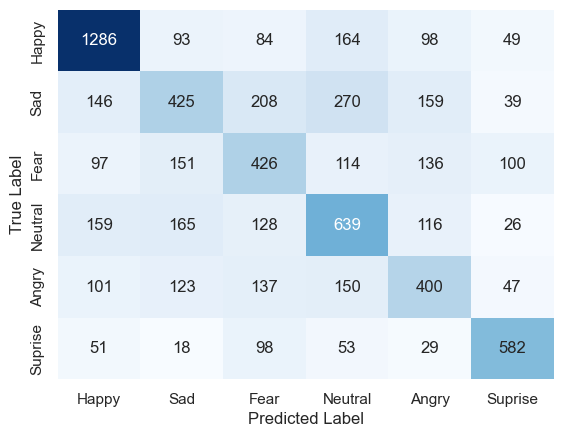

              precision    recall  f1-score   support

           0      0.699     0.725     0.712      1774
           1      0.436     0.341     0.383      1247
           2      0.394     0.416     0.405      1024
           3      0.460     0.518     0.487      1233
           4      0.426     0.418     0.422       958
           5      0.690     0.700     0.695       831

    accuracy                          0.532      7067
   macro avg      0.518     0.520     0.517      7067
weighted avg      0.529     0.532     0.529      7067



In [14]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

The history of the model shows that the loss increases for the validation set and decreases for the training set. Meanwhile the accuracy for the training set is increasing and the accuracy for the vlidation set is staying roughly flat.

The model isn't improving much.

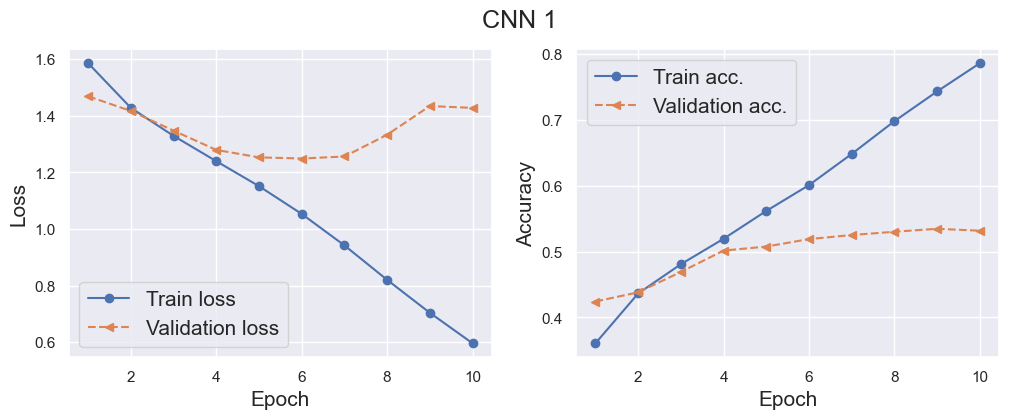

In [15]:
hist_CNN_1 = history_CNN_1.history
x_arr = np.arange(len(hist_CNN_1['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
plt.suptitle('CNN 1',fontsize=18)
ax.plot(x_arr, hist_CNN_1['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_CNN_1['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_CNN_1['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_CNN_1['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

Here's a breakdown of the model architecture that we chose.

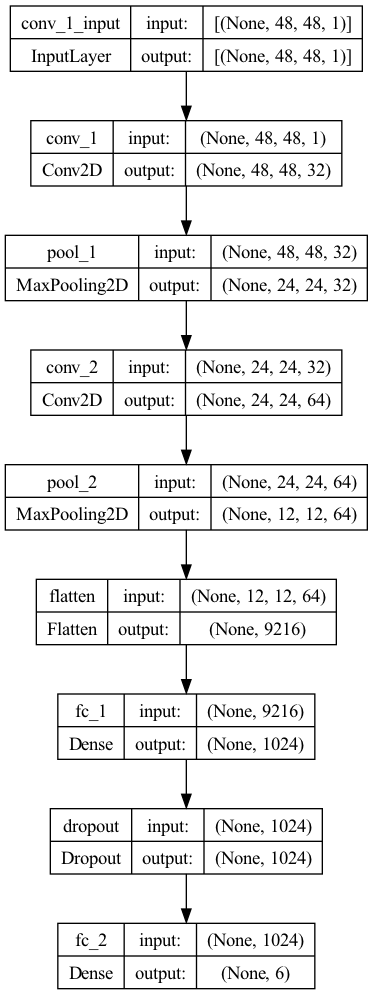

In [16]:
plot = plot_model(CNN_1, to_file='model.png', show_shapes=True, show_layer_names=True)
displayImage('model.png',width=300, height=200)


## Revising our CNN Model - 2nd Attempt

The first CNN model performed reasonably well - certainly better than our baseline FNN model. This is a good sign.

The accuracy of the model is somewhere around 54-55%. This is already better, we're getting just over half the images right, but we think that there's still room for improvement.

We'll attempt to modify our first model to improve performance by adjusting the kernel sizes and try SGD as the optimizer instead of Adam.

In [17]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [18]:
CNN_2 = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
CNN_2.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
CNN_2.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
##Same as hw
CNN_2.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
CNN_2.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
CNN_2.add(tf.keras.layers.Flatten()) 
CNN_2.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
CNN_2.add(tf.keras.layers.Dropout(
    rate=0.3))

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
CNN_2.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
CNN_2.build(input_shape=(None, 48, 48, 1))
CNN_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        544       
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 24, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 64)        32832     
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              9438208   
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

Adjusted the optimizer to SGD for the 2nd model:

In [19]:
##Changes optimizer and loss
CNN_2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['accuracy'])

In [20]:
##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history_CNN_2 = CNN_2.fit(X_train, Y_train,
                    epochs=20, 
                    validation_data=(X_test, Y_test)
)

Epoch 1/20
884/884 [==============================] - 17s 19ms/step - loss: 1.7399 - accuracy: 0.2630 - val_loss: 1.6984 - val_accuracy: 0.2979
Epoch 2/20
884/884 [==============================] - 17s 19ms/step - loss: 1.6676 - accuracy: 0.3158 - val_loss: 1.6380 - val_accuracy: 0.3504
Epoch 3/20
884/884 [==============================] - 17s 19ms/step - loss: 1.5946 - accuracy: 0.3696 - val_loss: 1.5613 - val_accuracy: 0.3847
Epoch 4/20
884/884 [==============================] - 17s 19ms/step - loss: 1.5434 - accuracy: 0.3913 - val_loss: 1.5220 - val_accuracy: 0.4055
Epoch 5/20
884/884 [==============================] - 17s 19ms/step - loss: 1.5002 - accuracy: 0.4115 - val_loss: 1.4867 - val_accuracy: 0.4187
Epoch 6/20
884/884 [==============================] - 17s 19ms/step - loss: 1.4615 - accuracy: 0.4309 - val_loss: 1.4546 - val_accuracy: 0.4268
Epoch 7/20
884/884 [==============================] - 17s 19ms/step - loss: 1.4237 - accuracy: 0.4438 - val_loss: 1.4234 - val_accuracy:

In [49]:
test_predictions = np.argmax(CNN_2.predict(X_test), axis=-1)
print(test_predictions)

221/221 [==============================] - 2s 7ms/step
[0 3 0 ... 5 5 5]


Now, we create a confusion matrix to visualize the results:

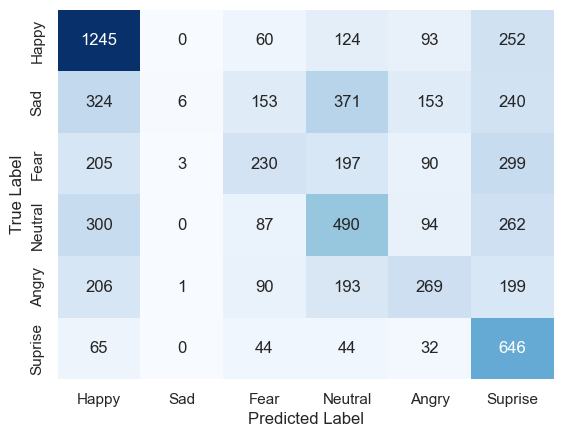

              precision    recall  f1-score   support

           0      0.531     0.702     0.605      1774
           1      0.600     0.005     0.010      1247
           2      0.346     0.225     0.273      1024
           3      0.345     0.397     0.370      1233
           4      0.368     0.281     0.319       958
           5      0.340     0.777     0.473       831

    accuracy                          0.408      7067
   macro avg      0.422     0.398     0.341      7067
weighted avg      0.439     0.408     0.356      7067



In [50]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

The model performs a bit worse than the 1st version of the CNN with the Adam optimizer.

The model training history:

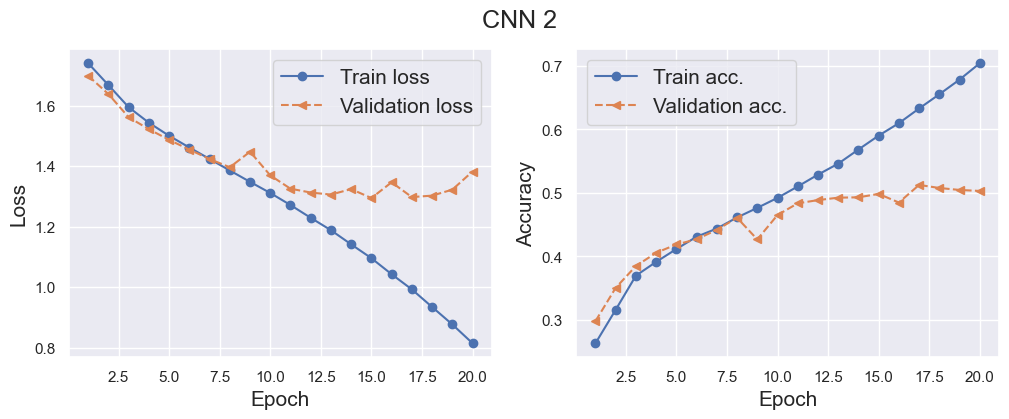

In [24]:
hist_CNN_2 = history_CNN_2.history
x_arr = np.arange(len(hist_CNN_2['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
plt.suptitle('CNN 2',fontsize=18)
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_CNN_2['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_CNN_2['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_CNN_2['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_CNN_2['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

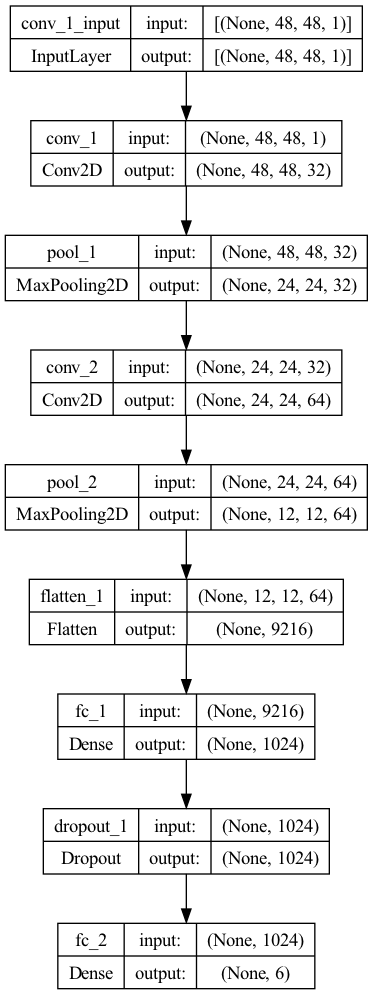

In [25]:
plot = plot_model(CNN_2, to_file='model.png', show_shapes=True, show_layer_names=True)
displayImage('model.png',width=300, height=200)


## New architecture needed... 3rd attempt with VGG 16

The second model performed similarly to the first. We decided to take a different approach. We found some other model architectures that have been popularized, particulary one called VGG 16.

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. 

It's considered to be a very high performing vision model architecture. 

Most unique thing about VGG16 is that instead of having a large number of hyper-parameters, they focused on having convolution layers of 3x3 filters with a stride of 1 and always used the same padding and maxpool layer of a 2x2 filter with a stride 2.

It has 16 layers with weights (hence the name VGG 16). This structure of convolution and max pool layers is followed consistently throughout the whole architecture.

The model has approximately 138 million parameters.

In [36]:
from keras.utils import to_categorical 

X_train_new = X_train.reshape(-1, 48, 48, 1) # Reshape to (batch_size, height, width, channels)
X_train_new = np.repeat(X_train_new, 3, axis=-1) 
X_train_new = preprocess_input(X_train_new) # Preprocess images using VGG16 preprocessing

# Preprocess and reshape the test images
X_test_new = X_test.reshape(-1, 48, 48, 1) # reshape to (batch_size, height, width, channels)
X_test_new = np.repeat(X_test_new, 3, axis=-1) 
X_test_new = preprocess_input(X_test_new) # Preprocess images

# Convert Y_train to one-hot encoded format
num_classes = len(label_names)
Y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
Y_test_encoded = to_categorical(Y_test, num_classes=num_classes)

In [37]:
print(Y_train_encoded.shape)
print(Y_test_encoded.shape)

(28273, 6)
(7067, 6)


In [43]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# from keras.utils import to_categorical 

X_train_new = X_train.reshape(-1, 48, 48, 1) # Reshape to (batch_size, height, width, channels)
X_train_new = np.repeat(X_train_new, 3, axis=-1) 
X_train_new = preprocess_input(X_train_new) # Preprocess images using VGG16 preprocessing

# Preprocess and reshape the test images
X_test_new = X_test.reshape(-1, 48, 48, 1) # reshape to (batch_size, height, width, channels)
X_test_new = np.repeat(X_test_new, 3, axis=-1) 
X_test_new = preprocess_input(X_test_new) # Preprocess images

# Convert Y_train to one-hot encoded format
num_classes = len(label_names)
Y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
Y_test_encoded = to_categorical(Y_test, num_classes=num_classes)

CNN3_model = VGG16(
    weights=None,
    include_top=False, 
    input_shape=(48, 48, 3)
)

CNN3 = Sequential()
CNN3.add(CNN3_model)
CNN3.add(Flatten())
CNN3.add(Dense(1000, activation="relu"))
CNN3.add(Dropout(0.4))
CNN3.add(Dense(6, activation="softmax"))

# Compile the model
CNN3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Train the model
history_CNN_3 = CNN3.fit(
    X_train_new, 
    Y_train_encoded,    
    epochs=15,
    batch_size=64,
    validation_data=(X_test_new, Y_test_encoded),
    verbose=1
)

Epoch 1/15
442/442 [==============================] - 63s 140ms/step - loss: 1.6010 - accuracy: 0.3312 - val_loss: 1.4221 - val_accuracy: 0.4255
Epoch 2/15
442/442 [==============================] - 63s 142ms/step - loss: 1.3000 - accuracy: 0.4789 - val_loss: 1.2303 - val_accuracy: 0.5118
Epoch 3/15
442/442 [==============================] - 64s 145ms/step - loss: 1.1494 - accuracy: 0.5426 - val_loss: 1.1649 - val_accuracy: 0.5411
Epoch 4/15
442/442 [==============================] - 68s 153ms/step - loss: 1.0312 - accuracy: 0.5946 - val_loss: 1.1154 - val_accuracy: 0.5635
Epoch 5/15
442/442 [==============================] - 68s 155ms/step - loss: 0.9072 - accuracy: 0.6506 - val_loss: 1.0962 - val_accuracy: 0.5828
Epoch 6/15
442/442 [==============================] - 67s 151ms/step - loss: 0.7701 - accuracy: 0.7122 - val_loss: 1.1556 - val_accuracy: 0.5761
Epoch 7/15
442/442 [==============================] - 68s 154ms/step - loss: 0.6203 - accuracy: 0.7716 - val_loss: 1.2288 - val_ac

In [44]:
# Predict using the preprocessed test images
test_predictions = np.argmax(CNN3.predict(X_test_new), axis=-1)
print(test_predictions)

221/221 [==============================] - 5s 20ms/step
[0 1 4 ... 5 5 0]


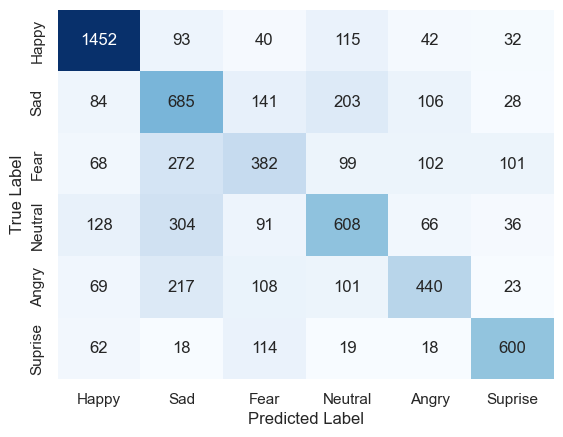

              precision    recall  f1-score   support

           0      0.779     0.818     0.798      1774
           1      0.431     0.549     0.483      1247
           2      0.436     0.373     0.402      1024
           3      0.531     0.493     0.511      1233
           4      0.568     0.459     0.508       958
           5      0.732     0.722     0.727       831

    accuracy                          0.590      7067
   macro avg      0.580     0.569     0.572      7067
weighted avg      0.591     0.590     0.587      7067



In [45]:
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

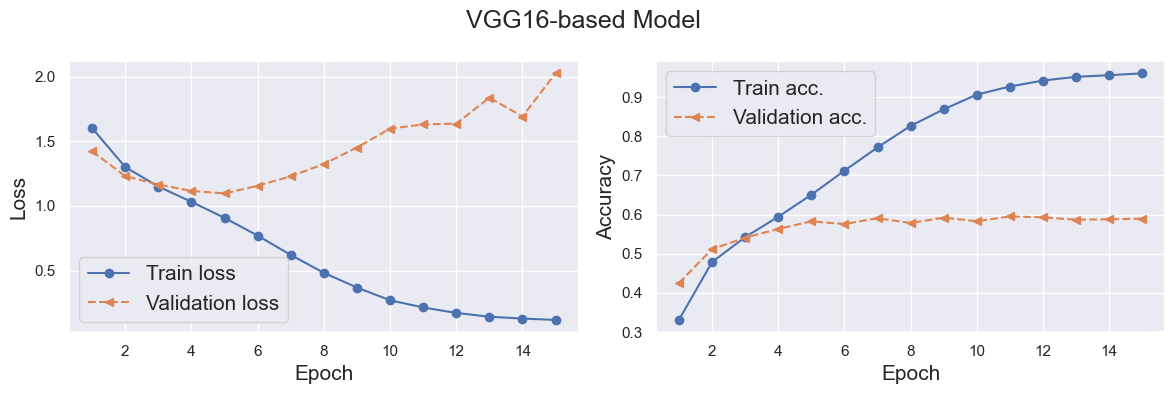

In [46]:
# Plot training and validation metrics
hist_CNN_3 = history_CNN_3.history
x_arr = np.arange(len(hist_CNN_3['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
plt.suptitle('VGG16-based Model', fontsize=18)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_CNN_3['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_CNN_3['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_CNN_3['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_CNN_3['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.tight_layout()
plt.show()

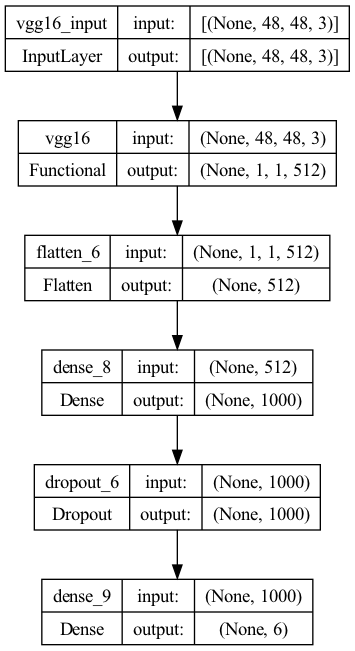

In [47]:
plot = plot_model(CNN3, to_file='model.png', show_shapes=True, show_layer_names=True)
displayImage('model.png',width=300, height=200)

## Conclusion

The VGG model outperformed the first and second CNN attempt but not by much.

The 3rd model was the best but the dataset seems hard to work with due to the inherent noise. More epochs and a larger training dataset would be helpful.